In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
import graphufs
from graphufs.utils import open_zarr, open_dataset

plt.style.use("graphufs.plotstyle")

/contrib2/Tim.Smith/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [17]:
psl = open_dataset("/p2-lustre/p2/inference/validation/graphufs_vs_hres_analysis_240h_deterministic_spatial.nc")
pslnative = open_dataset("/p2-lustre/p2/inference/validation/graphufs_vs_replay_240h_deterministic_spatial.nc")

In [8]:
gc = open_dataset("/p2-lustre/baselines/graphcast_vs_hres_analysis_2018_deterministic_spatial.nc")

In [9]:
def plot_row(axr, xds, metric, fields, cmap, level=None):
    kw = {} if level is None else {"level": level}
    for v, ax in zip(fields, axr):
        if v in xds:
            plotme = xds[v].sel(
                metric=metric,
                fhr=[6, 24, 48, 24*4, 24*6, 24*8, 24*10],
            ).sel(
                **kw,
                method="nearest",
            ).mean(
                "longitude",
            )
            n_time = len(plotme.fhr)
            for itime in range(n_time):
                plotme.isel(fhr=itime).plot.line(
                    x="latitude",
                    ax=ax,
                    add_legend=False,
                    color=plt.get_cmap(cmap)(int(itime/n_time * 256)),
                    label=f"{int(plotme.fhr.isel(fhr=itime)): 3d}h",
                )
            sps = ax.get_subplotspec()
            ax.set(
                ylabel="",
                xlabel="Latitude" if sps.is_last_row() else "",
                title=" ".join([x.capitalize() if x != "of" else x for x in v.split("_")]) if sps.is_first_row() else "",
                
            )
    axr[-1].legend(title="Forecast Hour", bbox_to_anchor=(1., .55), loc="center left")

In [10]:
def plot_surface(
    xds,
    metric="mae",
    cmap="plasma",
    fields=("2m_temperature", "surface_pressure", "10m_u_component_of_wind", "10m_v_component_of_wind"),
):

    ncols = len(fields)
    fig, axs = plt.subplots(1, ncols, figsize=(4*ncols, 4), constrained_layout=True, sharex=True)
    plot_row(axs, xds, metric, fields, cmap)
    fig.suptitle(f"{metric.upper()} vs Replay")
    
    return fig, axs

In [15]:
def plot_levels(
    xds,
    metric="mae",
    cmap="plasma",
    fields=("geopotential", "temperature", "specific_humidity", "u_component_of_wind", "v_component_of_wind"),
    levels=(250, 500, 1000),
):
    nrows = len(levels)
    ncols = len(fields)
    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), constrained_layout=True, sharex=True)
    for level, axr in zip(levels, axs):
        plot_row(axr, xds, metric, fields, cmap, level=level)
        axr[0].set(ylabel=f"~{int(xds.sel(level=level, method='nearest').level.values)} hPa")
    fig.suptitle(f"{metric.upper()} vs Replay")
    return fig, axs

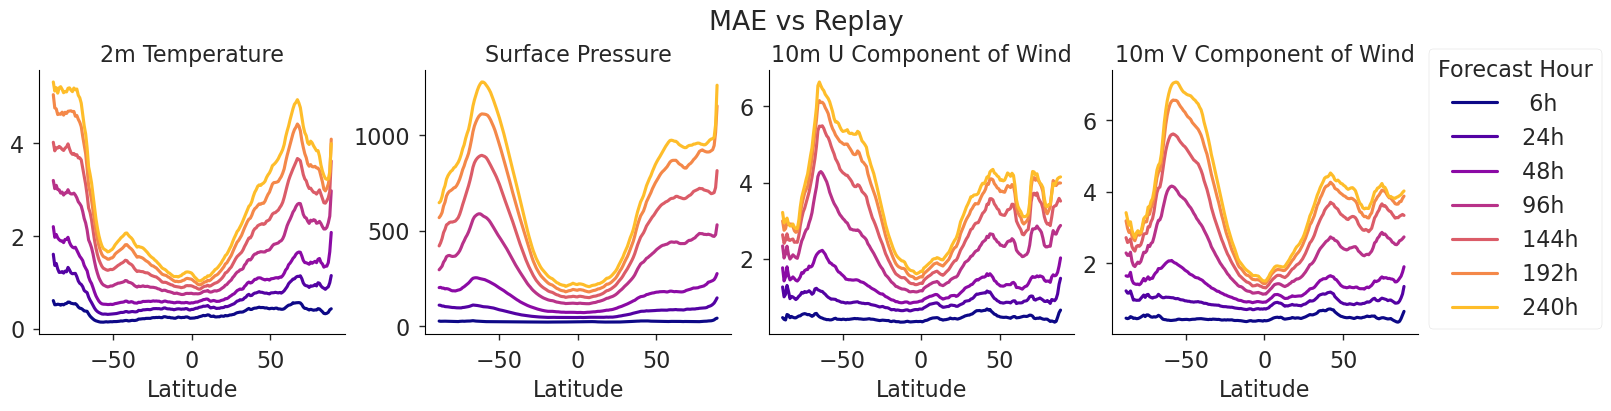

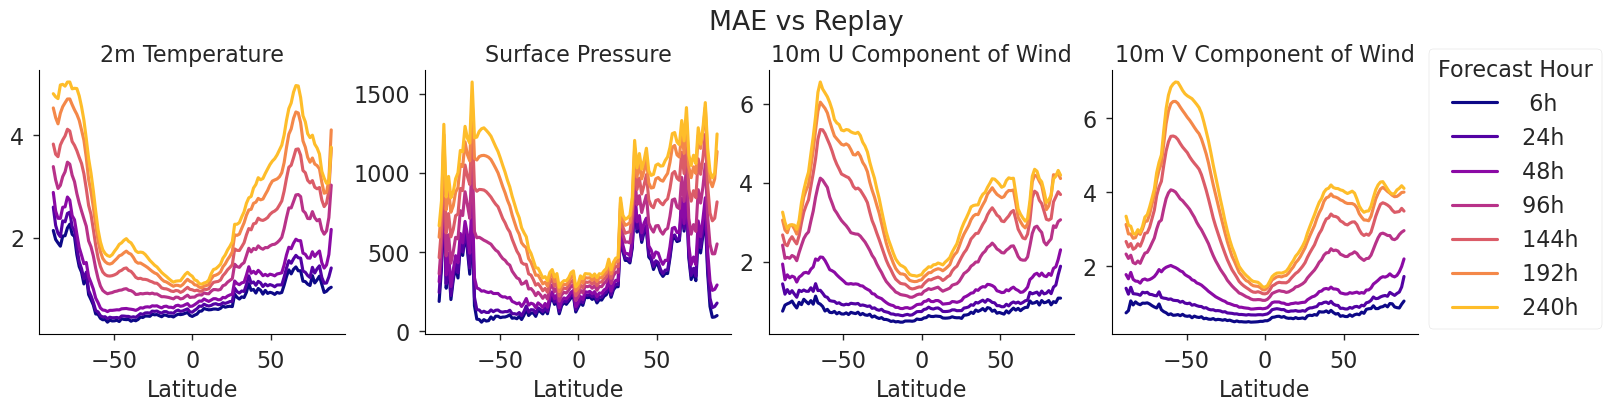

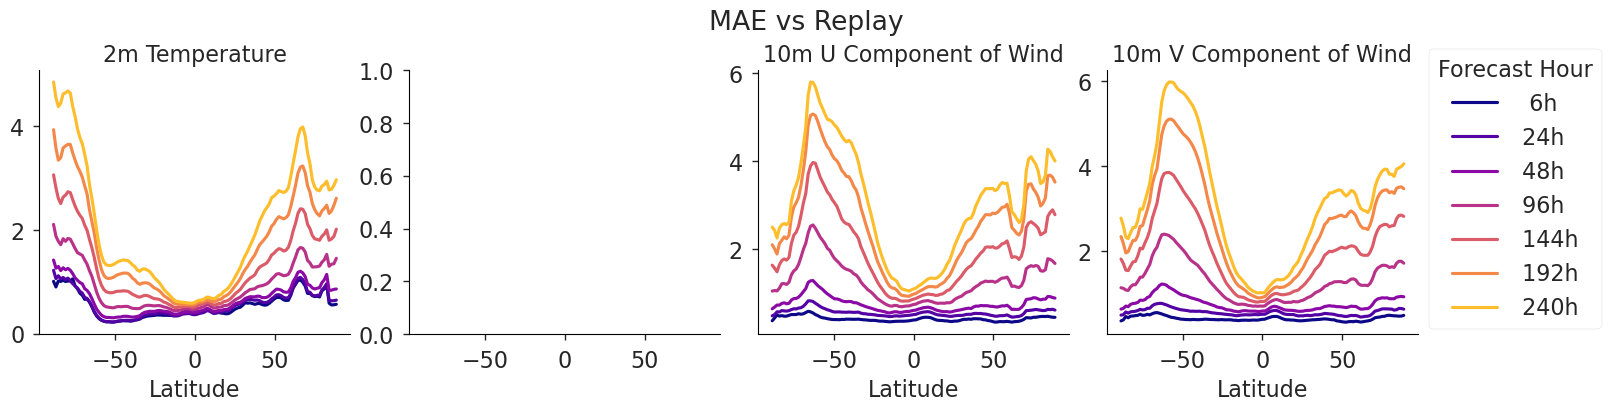

In [18]:
plot_surface(pslnative);
plot_surface(psl);
plot_surface(gc);


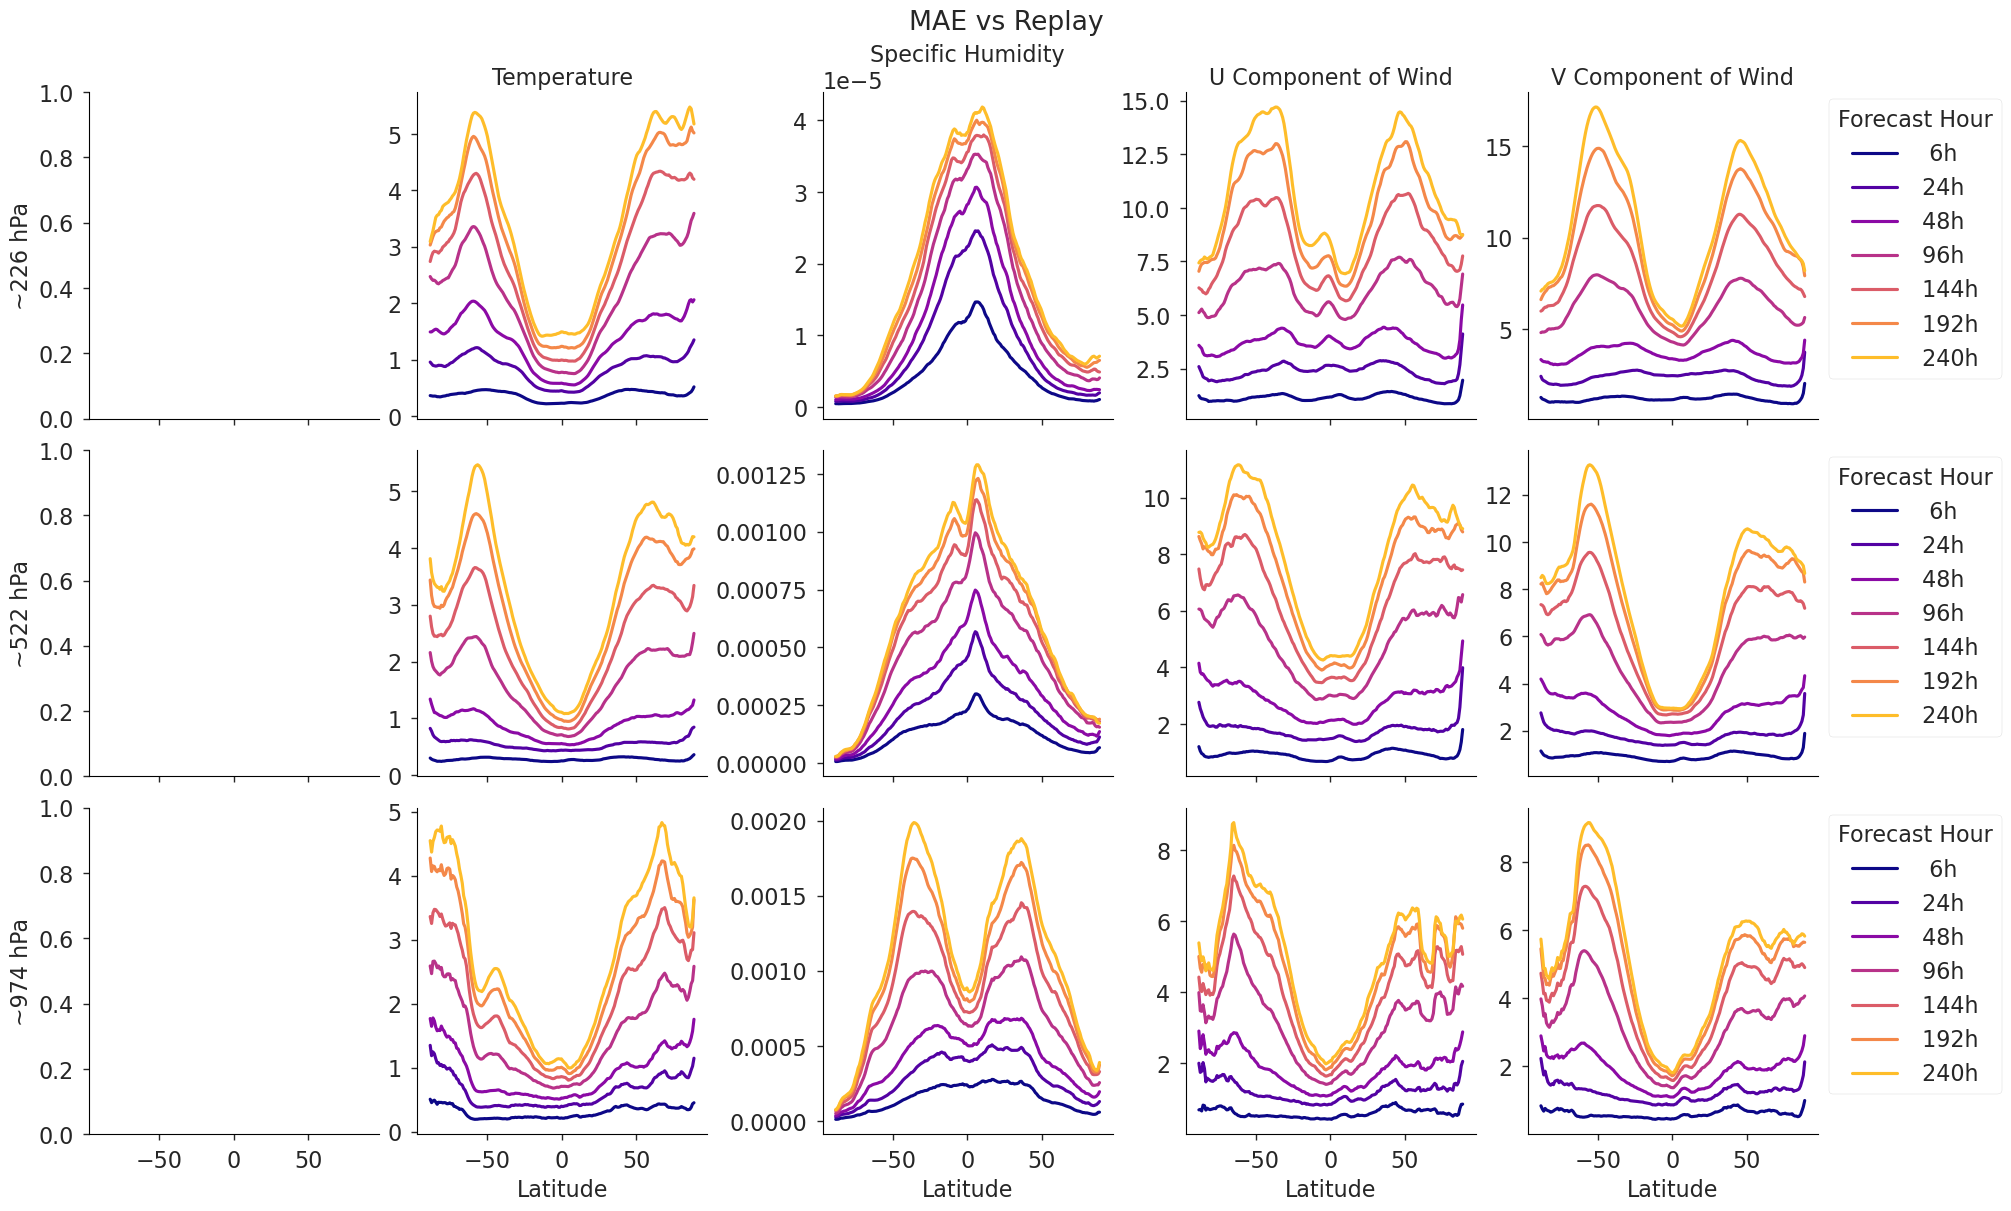

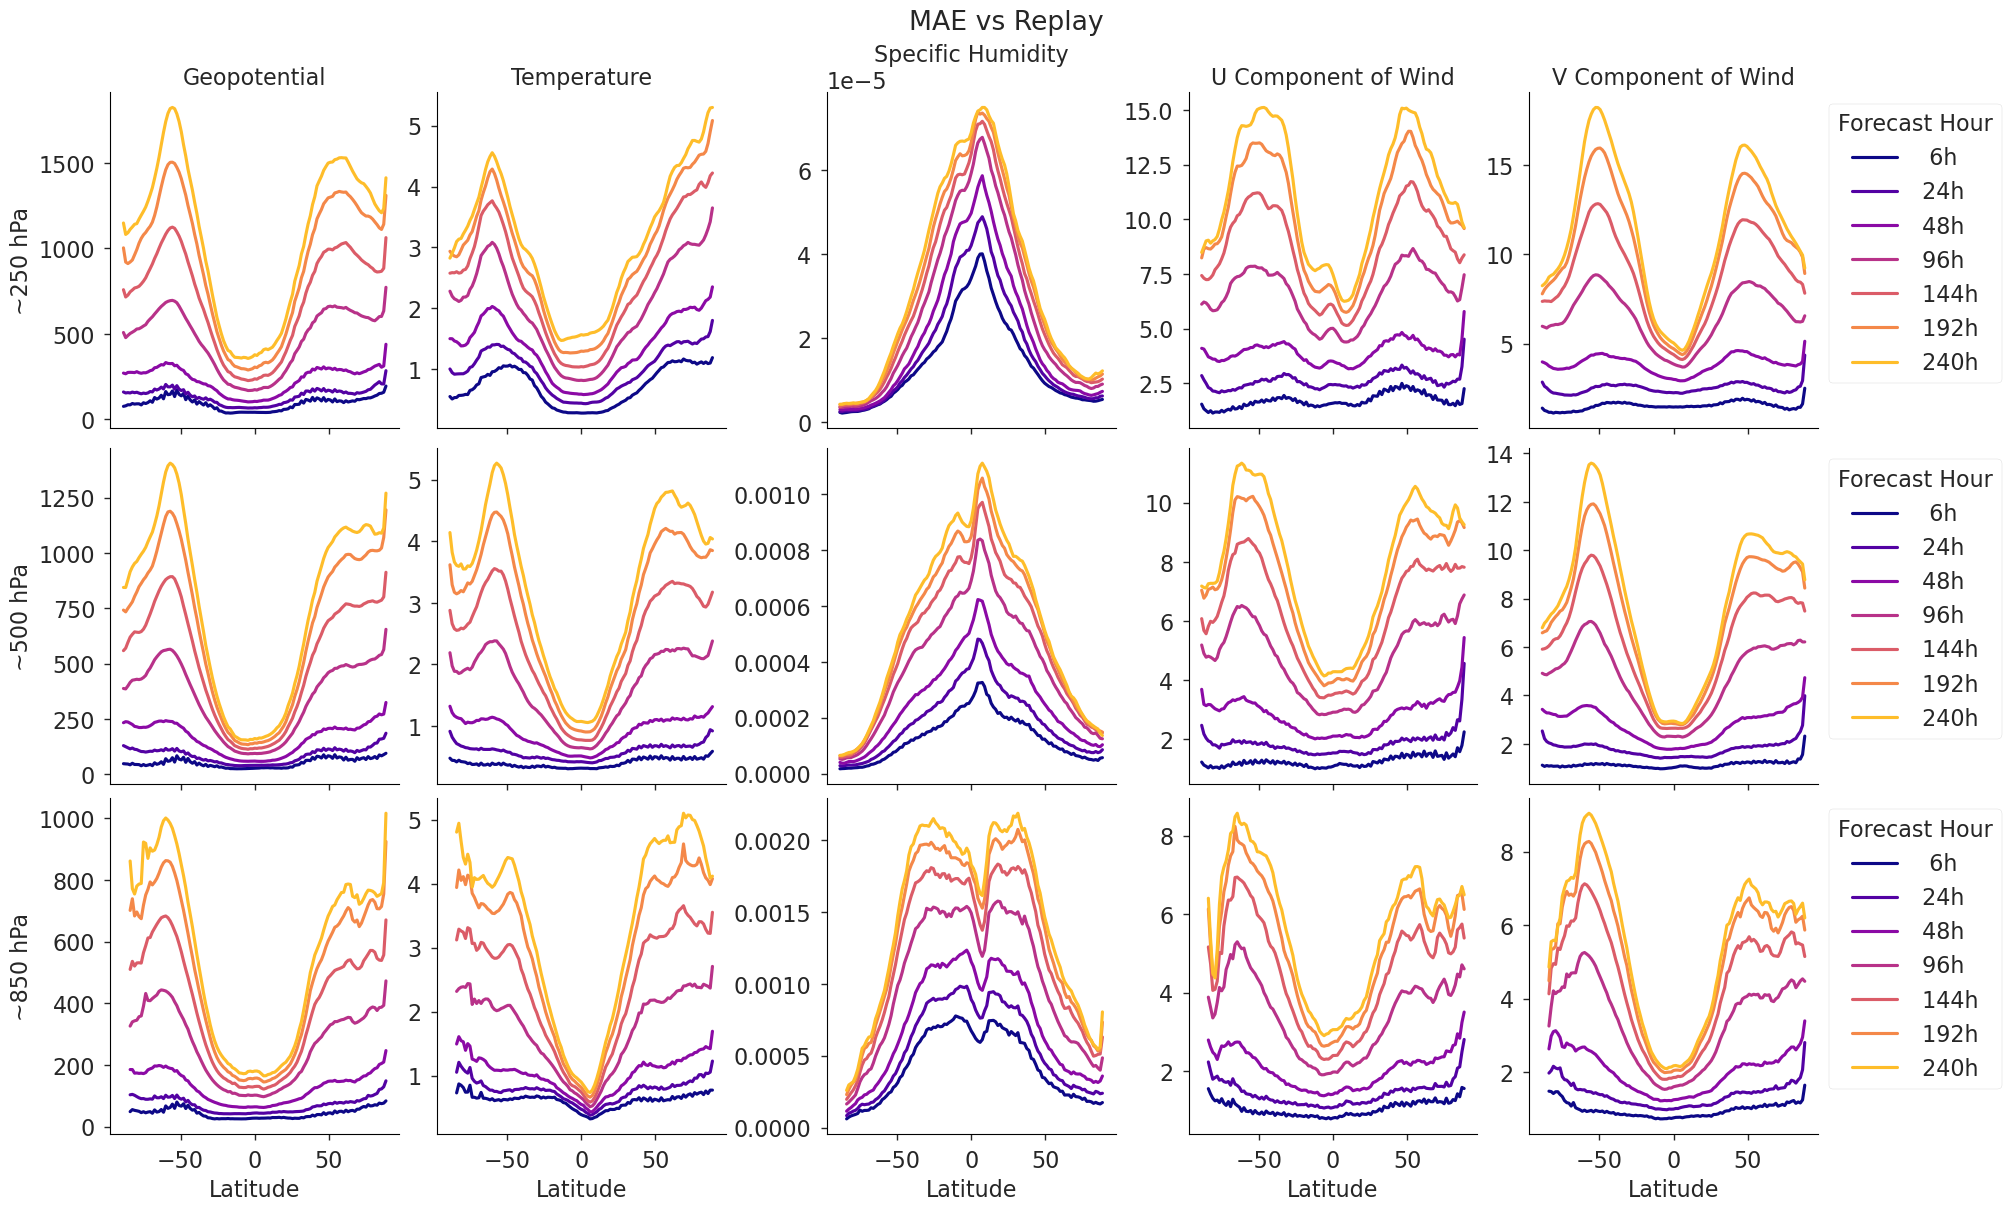

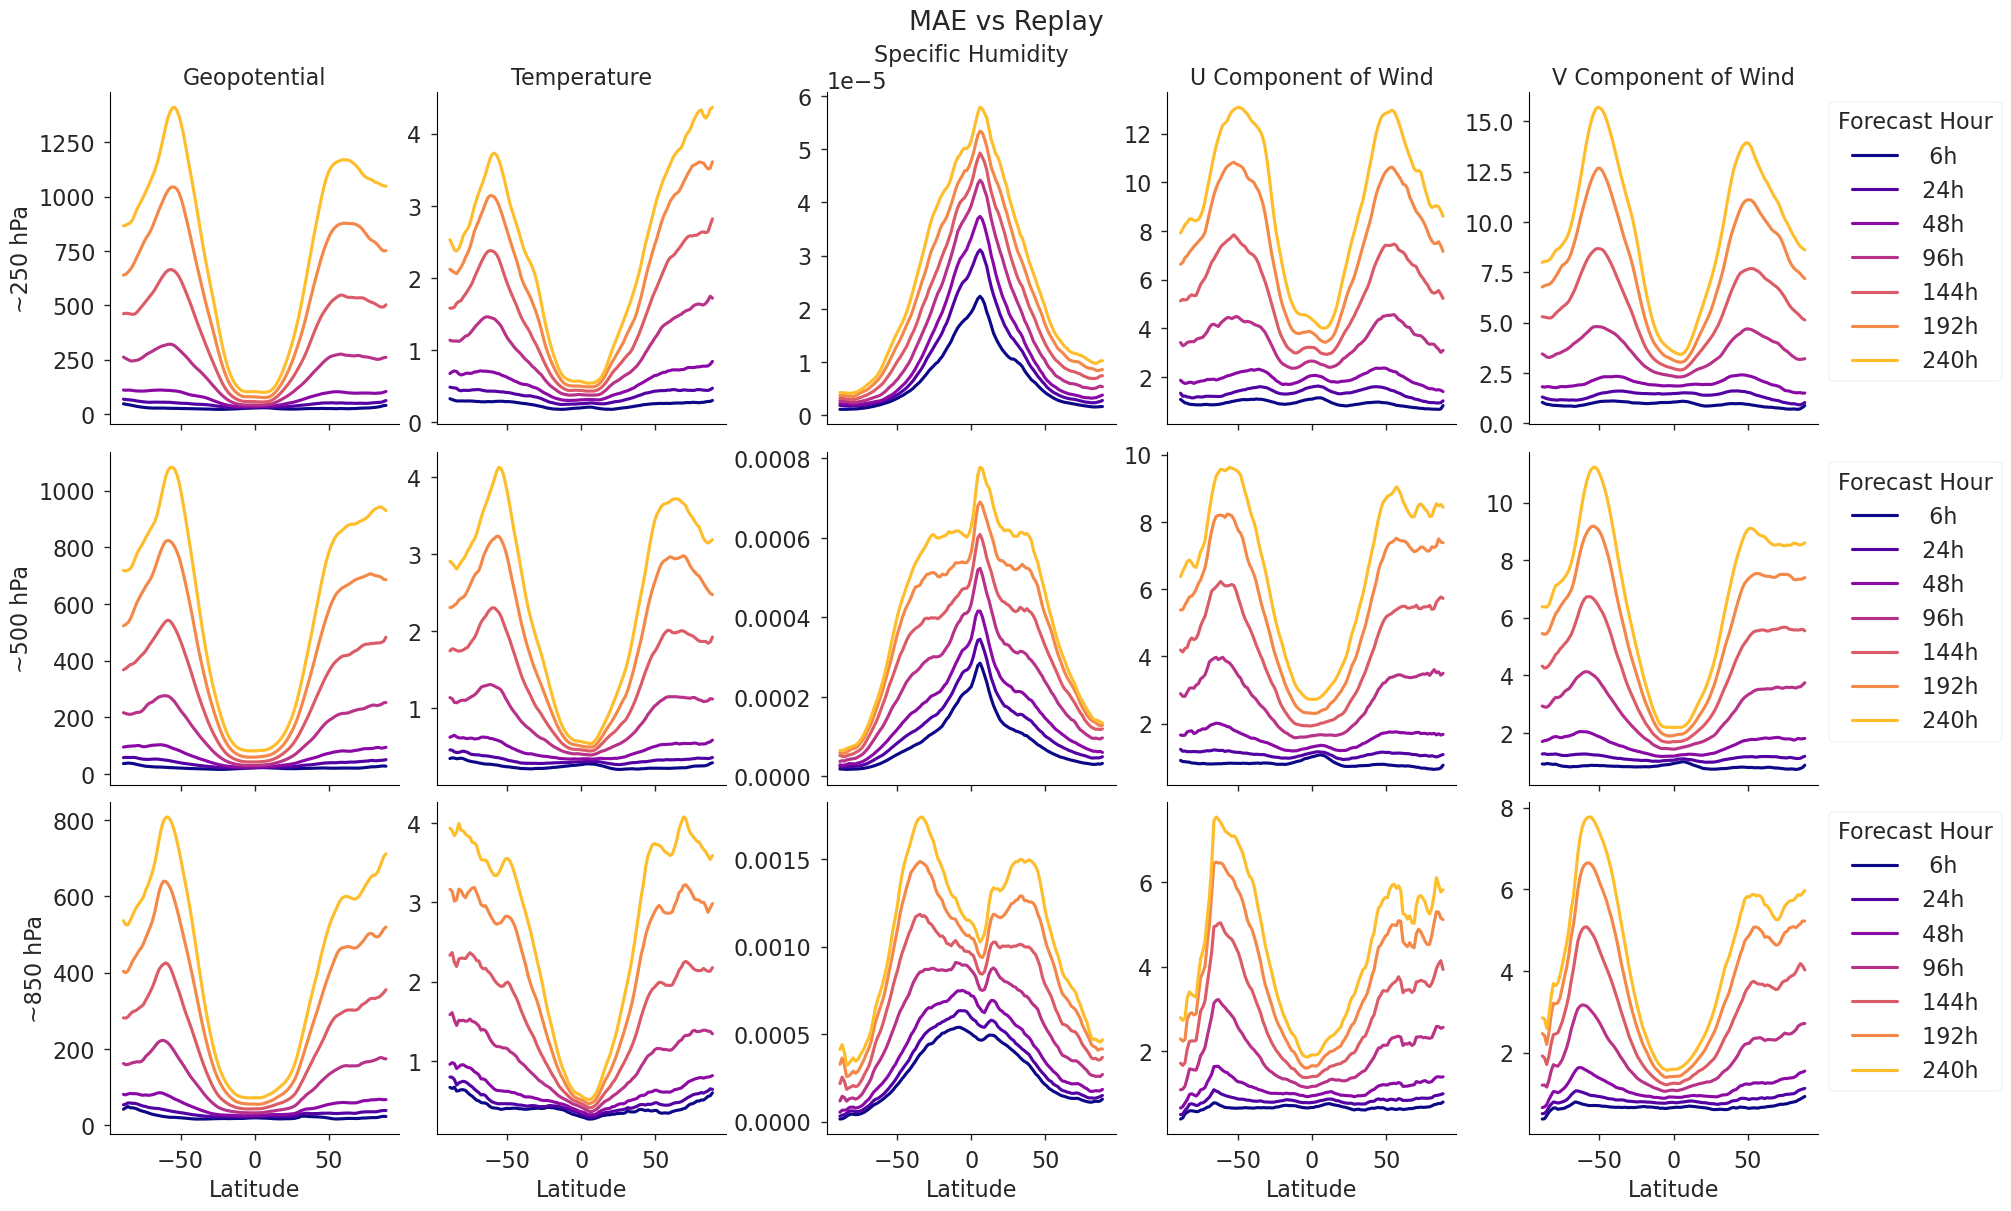

In [19]:
plot_levels(pslnative);
plot_levels(psl);
plot_levels(gc);